In [1]:
# cell 1
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

from config import (IMG_HEIGHT, IMG_WIDTH, NUM_FIDUCIAL,
                    INPUT_CHANNEL, OUTPUT_CHANNEL, HIDDEN_SIZE,
                    CHARACTERS, MAX_LABEL_LENGTH)
from dataset import LmdbDataset, AlignCollate
# from utils import CTCLabelConverter, Averager
from utils import AttnLabelConverter, Averager
from model import CRNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)


Running on cuda


In [2]:
# ─── cell 0: reproducibility ────────────────────────────────────────────────
SEED = 300188
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Make cuDNN deterministic (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"All seeds set to {SEED}, cudnn.deterministic={torch.backends.cudnn.deterministic}")

All seeds set to 300188, cudnn.deterministic=True


In [3]:
# cell 2
# paths to your LMDBs
train_lmdb = "generated_lmdb_data/train"
val_lmdb   = "generated_lmdb_data/val"

# instantiate datasets
train_dataset = LmdbDataset(train_lmdb)
val_dataset   = LmdbDataset(val_lmdb)

# collate_fn resizes + normalizes
collate_fn = AlignCollate(
    imgH=IMG_HEIGHT, imgW=IMG_WIDTH, keep_ratio_with_pad=False
)

# loaders
BATCH_SIZE = 128
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, collate_fn=collate_fn, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, collate_fn=collate_fn, pin_memory=True
)

print(f"{len(train_dataset)} train / {len(val_dataset)} val samples")

Loaded 8000 valid samples from generated_lmdb_data/train
Loaded 2000 valid samples from generated_lmdb_data/val
8000 train / 2000 val samples


In [4]:
converter   = AttnLabelConverter(CHARACTERS)
num_classes = len(converter.character)   # includes [GO] and [s]

model = CRNN(
    IMG_HEIGHT,      # imgH
    IMG_WIDTH,       # imgW
    INPUT_CHANNEL,   # input_channel
    OUTPUT_CHANNEL,  # output_channel
    HIDDEN_SIZE,     # hidden_size
    num_classes,     # num_classes (with GO/s)
    True,            # use_attention
    NUM_FIDUCIAL     # num_fiducial
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

model.Transformation = nn.Identity() # <-- no transformation

In [5]:
# ─── cell 4: validate (Attention) ─────────────────────────────────────────────
NUM_EPOCHS       = 500
PRINT_EVERY      = len(train_dataset) // BATCH_SIZE + 1
PATIENCE       = 100          # stop if no val_acc ↑ for 50 epochs

def validate(model, loader):
    model.eval()
    avg_loss = Averager()
    correct, total = 0, 0

    with torch.no_grad():
        for images, texts in loader:
            images = images.to(device)

            # encode full text → shape [B, L+1], plus lengths
            text, length = converter.encode(texts, batch_max_length=MAX_LABEL_LENGTH)
            text_input  = text[:, :-1].to(device)  # drop final [s]
            text_target = text[:,  1:].to(device)  # everything after [GO]

            # forward
            preds = model(images, text_input, is_train=False,
                          batch_max_length=MAX_LABEL_LENGTH)
            B, S, C = preds.size()

            # cross‐entropy over (B×S) predictions
            loss = criterion(
                preds.view(B * S, C),
                text_target.contiguous().view(B * S)
            )
            avg_loss.add(loss)

            # greedy decode
            _, pred_inds = preds.max(2)                   # [B, S]
            pred_strs = converter.decode(pred_inds, length)  # pass length

            # strip off anything after the "[s]" token
            pred_strs = [s.split('[s]')[0] for s in pred_strs]

            total += len(texts)
            correct += sum(p == g for p, g in zip(pred_strs, texts))

    acc = correct / total * 100
    return avg_loss.val(), acc


In [6]:
# ─── cell 5: load pretrained CTC weights (skip old Prediction head) ────────────

from collections import OrderedDict

orig      = torch.load("pretrained_model/TPS-ResNet-BiLSTM-Attn.pth", map_location=device)
# strip off the "module." prefix if you wrapped in DataParallel
stripped  = OrderedDict((k[len("module."):], v)
                        for k, v in orig.items()
                        if k.startswith("module."))

own = model.state_dict()
for k, v in stripped.items():
    # skip the old attention head entirely
    if k.startswith("Prediction.") or k.startswith("Transformation."):
        continue
    # only overwrite if shapes match
    if k in own and v.size() == own[k].size():
        own[k] = v

model.load_state_dict(own)
print("✅ Loaded pretrained Attn weights")


✅ Loaded pretrained Attn weights


In [7]:
# ─── Cell 6: training w/ history, best‐model saving + EARLY STOPPING ───

# hyper‑params
best_val_acc   = 0.0
history        = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_acc': []}

patience_cnt   = 0           # how many epochs since last improvement

for epoch in range(1, NUM_EPOCHS+1):
    print(f"→ Starting epoch {epoch}  (printing every {PRINT_EVERY} iters)")
    model.train()
    epoch_loss = Averager()
    start = time.time()

    # ─── training ──────────────────────────────────────────────────────────
    for i, (images, texts) in enumerate(train_loader, 1):
        images = images.to(device)

        text, length   = converter.encode(texts, batch_max_length=MAX_LABEL_LENGTH)
        text_input     = text[:, :-1].to(device)
        text_target    = text[:,  1:].to(device)

        preds = model(
            images,
            text=text_input,
            is_train=True,
            batch_max_length=MAX_LABEL_LENGTH
        )  # [B, S, C]
        B, S, C = preds.size()
        loss = criterion(
            preds.view(B * S, C),
            text_target.contiguous().view(B * S)
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        epoch_loss.add(loss)

        # mini‐table prints
        if i % PRINT_EVERY == 0:
            print(f"[Epoch {epoch}] iter {i}/{len(train_loader)}, avg loss: {epoch_loss.val():.4f}", flush=True)
            with torch.no_grad():
                probs     = preds.softmax(2)
                max_vals, max_inds = probs.max(2)
                pred_strs = converter.decode(max_inds, length)
                pred_strs = [s.split('[s]')[0] for s in pred_strs]

            print("-" * 80)
            print(f"{'Ground Truth':25s} | {'Prediction':25s} | AvgConfidence")
            print("-" * 80)
            for gt, pr, conf_seq in zip(texts[:5], pred_strs[:5], max_vals[:5]):
                conf = conf_seq.mean().item()
                print(f"{gt:25s} | {pr:25s} | {conf_seq.mean().item():.4f}")
            print("-" * 80)

    # ─── validation ────────────────────────────────────────────────────────
    val_loss, val_acc = validate(model, val_loader)
    elapsed   = time.time() - start
    train_l   = epoch_loss.val()
    print(f"==> Epoch {epoch} done in {elapsed:.1f}s | "
          f"train_loss={train_l:.4f}  valid_loss={val_loss:.4f}  valid_acc={val_acc:.2f}%\n")

    # ─── record history ───────────────────────────────────────────────────
    history['epoch'].append(epoch)
    history['train_loss'].append(train_l)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # ─── best‑model tracking & early‑stopping logic ───────────────────────
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_attention_crnn_generated_dataset.pth")
        print(f"💾 New best model saved (epoch {epoch}, val_acc={val_acc:.2f}%)\n")
        patience_cnt = 0                          # reset counter
    else:
        patience_cnt += 1
        print(f"no improvement for {patience_cnt}/{PATIENCE} epochs\n")
        if patience_cnt >= PATIENCE:
            print(f"🔚 Early stopping: val_acc hasn't improved for {PATIENCE} epochs.")
            break


→ Starting epoch 1  (printing every 63 iters)
[Epoch 1] iter 63/63, avg loss: 3.1041
--------------------------------------------------------------------------------
Ground Truth              | Prediction                | AvgConfidence
--------------------------------------------------------------------------------
VDH29                     | H9999                     | 0.3974
WB10B                     | B888888                   | 0.2473
JBS367                    | B6666                     | 0.3816
DQO6216E                  | 6666666                   | 0.2552
YV147Z                    | Z777                      | 0.3551
--------------------------------------------------------------------------------
==> Epoch 1 done in 10.4s | train_loss=3.1041  valid_loss=2.6962  valid_acc=0.00%

no improvement for 1/100 epochs

→ Starting epoch 2  (printing every 63 iters)
[Epoch 2] iter 63/63, avg loss: 2.3607
--------------------------------------------------------------------------------
Groun

,epoch,train_loss,val_loss,val_acc
0,1,3.104064,2.696229,0.00
1,2,2.360739,1.903633,1.05
2,3,1.628060,1.148686,12.00
3,4,1.137536,1.087282,14.55
4,5,0.846556,1.788725,6.30
...,...,...,...,...
128,129,0.000085,0.267703,76.70
129,130,0.000084,0.267677,76.65
130,131,0.000084,0.268005,76.75
131,132,0.000085,0.266264,76.75


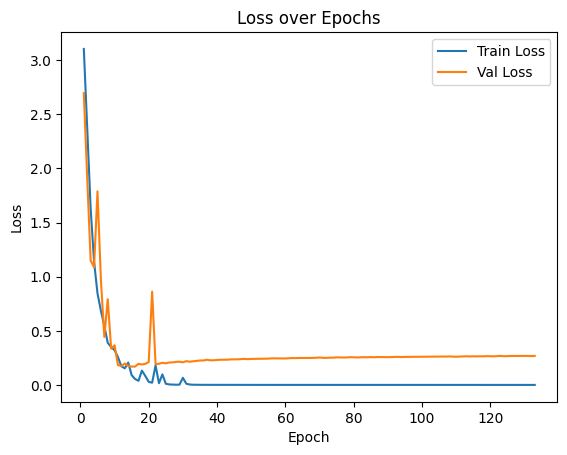

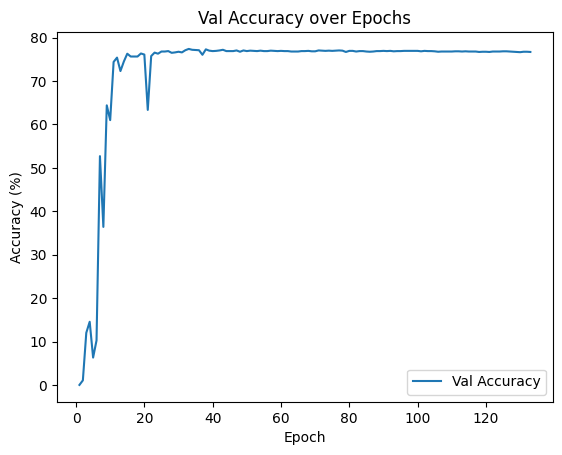

In [11]:
clean_history = {
  'epoch':      history['epoch'],
  'train_loss': [x.cpu().item() if hasattr(x, 'cpu') else x for x in history['train_loss']],
  'val_loss':   [x.cpu().item() if hasattr(x, 'cpu') else x for x in history['val_loss']],
  'val_acc':    [x.cpu().item() if hasattr(x, 'cpu') else x for x in history['val_acc']],
}
df = pd.DataFrame(clean_history)
display(df)

plt.figure()
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Loss over Epochs')
plt.show()

plt.figure()
plt.plot(df['epoch'], df['val_acc'],   label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
plt.title('Val Accuracy over Epochs')
plt.show()

In [9]:
# # ─── Cell 9: ONNX export via isolated inference head ─────────────────────────
# import torch

# class CRNNInference(torch.nn.Module):
#     def __init__(self, crnn, max_len):
#         super().__init__()
#         # use exactly the names printed out by your inspection
#         self.Transformation     = crnn.Transformation
#         self.FeatureExtraction = crnn.FeatureExtraction
#         self.AdaptiveAvgPool    = crnn.AdaptiveAvgPool
#         self.SequenceModeling   = crnn.SequenceModeling
#         self.Prediction         = crnn.Prediction
#         self.max_len           = max_len
#         # adjust this if your converter stores start-token under a different key
#         self.start_id          = crnn.converter.dict['[GO]']

#     def forward(self, image):
#         # 1) Spatial‐transformer + feature CNN
#         x = self.Transformation(image)                     # [B, C, H, W]
#         x = self.FeatureExtraction(x)                      # [B, C, H, W]

#         # 2) Pool down height to 1
#         x = self.AdaptiveAvgPool(x)                        # [B, C, 1, W]
#         x = x.squeeze(2)                                   # [B, C, W]
#         x = x.permute(0, 2, 1)                             # [B, W, C]

#         # 3) 2‐layer BiLSTM
#         contextual = self.SequenceModeling(x)              # [B, W, hidden]

#         # 4) Dummy “[GO]” token vector
#         B = contextual.size(0)
#         dummy_text = torch.full(
#             (B,),
#             self.start_id,
#             dtype=torch.long,
#             device=image.device
#         )  # shape [B]

#         # 5) Attention decoder (inference path)
#         return self.Prediction(
#             batch_H           = contextual,
#             text              = dummy_text,
#             is_train          = False,
#             batch_max_length  = self.max_len
#         )

# # Wrap and export
# inference_model = CRNNInference(model, BATCH_MAX_LENGTH).eval()
# dummy_img       = torch.randn(1, INPUT_CHANNEL, IMG_HEIGHT, IMG_WIDTH, device=device)

# torch.onnx.export(
#     inference_model,
#     dummy_img,
#     "best_attention_crnn.onnx",
#     input_names   = ['image'],
#     output_names  = ['logits'],
#     dynamic_axes  = {
#         'image':  {0: 'batch'},
#         'logits': {0: 'batch', 1: 'time'}
#     },
#     opset_version = 13,
# )

# print("✅ Exported best_attention_crnn.onnx")


# DUMP

In [10]:
# # ─── cell 6: attention‐based training loop ──────────────────────────────────────
# for epoch in range(1, NUM_EPOCHS+1):
#     print(f"→ Starting epoch {epoch}  (printing every {PRINT_EVERY} iters)")
#     model.train()
#     epoch_loss = Averager()
#     start      = time.time()

#     for i, (images, texts) in enumerate(train_loader, 1):
#         images = images.to(device)

#         # encode with [GO] & [s]; also get lengths
#         text, length = converter.encode(texts, batch_max_length=BATCH_MAX_LENGTH)
#         text_input  = text[:, :-1].to(device)   # drop final [s]
#         text_target = text[:,  1:].to(device)   # everything after [GO]

#         # forward + loss
#         preds = model(images,
#                       text=text_input,
#                       is_train=True,
#                       batch_max_length=BATCH_MAX_LENGTH)  # [B, S, C]
#         B, S, C = preds.size()
#         loss = criterion(
#             preds.view(B * S, C),
#             text_target.contiguous().view(B * S)
#         )

#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
#         optimizer.step()
#         epoch_loss.add(loss)

#         if i % PRINT_EVERY == 0 or i == 1:
#             print(f"[Epoch {epoch}] iter {i}/{len(train_loader)}, avg loss: {epoch_loss.val():.4f}", flush=True)

#             # quick greedy‐decode
#             with torch.no_grad():
#                 probs        = preds.softmax(2)           # [B, S, C]
#                 max_vals, max_inds = probs.max(2)         # [B, S]
#                 pred_strs    = converter.decode(max_inds, length)
#                 pred_strs    = [s.split('[s]')[0] for s in pred_strs]

#             # print a mini‐table
#             print("-" * 80)
#             print(f"{'Ground Truth':25s} | {'Prediction':25s} | AvgConfidence")
#             print("-" * 80)
#             for gt, pr, conf_seq in zip(texts[:5], pred_strs[:5], max_vals[:5]):
#                 conf = conf_seq.mean().item()
#                 print(f"{gt:25s} | {pr:25s} | {conf:0.4f}")
#             print("-" * 80)

#     # end‐of‐epoch validation
#     val_loss, val_acc = validate(model, val_loader)
#     elapsed = time.time() - start
#     print(f"==> Epoch {epoch} done in {elapsed:.1f}s | "
#           f"train_loss={epoch_loss.val():.4f}"
#           f"  valid_loss={val_loss:.4f}  valid_acc={val_acc:.2f}%\n")
